# Multi-Class Deep Learning Model for Sign Language MNIST Using TensorFlow Take 2
### David Lowe
### November 20, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Sign Language MNIST dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods. The Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows to stimulate the community to develop more drop-in replacements. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z, which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 instances) are approximately half the size of the standard MNIST but otherwise similar with a header row of the labels, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds.

In iteration Take1, we constructed a Multilayer Perceptron (MLP) model with five hidden layers to model this dataset.

In this Take2 iteration, we will construct a Convolutional Neural Network (CNN) model with five hidden layers to model this dataset.

ANALYSIS: From iteration Take1, the MLP model's performance achieved an accuracy score of 94.93% after 50 epochs using the training dataset. The same model processed the test dataset with an accuracy score of 77.93%, which pointed to a high variance error.

In this Take2 iteration, the CNN model's performance achieved an accuracy score of 99.94% after 25 epochs using the training dataset. The same model processed the test dataset with an accuracy score of 99.55%, which pointed to a high variance error.

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: Sign Language MNIST Dataset

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://www.kaggle.com/datamunge/sign-language-mnist

One source of potential performance benchmarks: https://www.kaggle.com/datamunge/sign-language-mnist

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL boto3

     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 133kB 7.7MB/s 
     |████████████████████████████████| 6.8MB 7.6MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 133kB 43.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Nov 12 00:47:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds and iterations for cross validation
n_folds = 5
n_iterations = 2

# Set various default modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 25
default_batch = 32
input_image_size = (28, 28, 1)
num_class = 24

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [9]:
# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 1.c) Load Dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-sign-language-mnist/sign_mnist_train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_original.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Data columns (total 785 columns):
 #   Column    Dtype
---  ------    -----
 0   label     int64
 1   pixel1    int64
 2   pixel2    int64
 3   pixel3    int64
 4   pixel4    int64
 5   pixel5    int64
 6   pixel6    int64
 7   pixel7    int64
 8   pixel8    int64
 9   pixel9    int64
 10  pixel10   int64
 11  pixel11   int64
 12  pixel12   int64
 13  pixel13   int64
 14  pixel14   int64
 15  pixel15   int64
 16  pixel16   int64
 17  pixel17   int64
 18  pixel18   int64
 19  pixel19   int64
 20  pixel20   int64
 21  pixel21   int64
 22  pixel22   int64
 23  pixel23   int64
 24  pixel24   int64
 25  pixel25   int64
 26  pixel26   int64
 27  pixel27   int64
 28  pixel28   int64
 29  pixel29   int64
 30  pixel30   int64
 31  pixel31   int64
 32  pixel32   int64
 33  pixel33   int64
 34  pixel34   int64
 35  pixel35   int64
 36  pixel36   int64
 37  pixel37   int64
 38  pixel38   int64
 39  pixel39   int64
 40  pix

In [15]:
Xy_original.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [16]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe: 0


## 1.d) Data Cleaning

In [17]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'label': 'targetVar'})

## 1.e) Splitting Data into Sets

In [18]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_train_df = Xy_original.iloc[:,0:totAttr]
    y_train_df = Xy_original.iloc[:,totAttr]
else:
    X_train_df = Xy_original.iloc[:,1:totCol]
    y_train_df = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_train_df.shape: {} y_train_df.shape: {}".format(Xy_original.shape, X_train_df.shape, y_train_df.shape))

Xy_original.shape: (27455, 785) X_train_df.shape: (27455, 784) y_train_df.shape: (27455,)


In [20]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-sign-language-mnist/sign_mnist_test.csv'
Xy_test = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel4

In [21]:
# Standardize the class column to the name of targetVar if required
Xy_test = Xy_test.rename(columns={'label': 'targetVar'})

In [22]:
X_test_df = Xy_test.iloc[:,1:totCol]
y_test_df = Xy_test.iloc[:,0]
print("Xy_test.shape: {} X_test_df.shape: {} y_test_df.shape: {}".format(Xy_test.shape, X_test_df.shape, y_test_df.shape))

Xy_test.shape: (7172, 785) X_test_df.shape: (7172, 784) y_test_df.shape: (7172,)


In [23]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [26]:
# # Histograms for each attribute
# X_train_df.hist(layout=(dispRow,dispCol))
# plt.show()

In [27]:
# # Box and Whisker plot for each attribute
# X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
# plt.show()

In [28]:
# # Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_train_df.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [29]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [30]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Transformation

In [31]:
# Normalize the data to reduce the effect of illumination's differences and help the CNN converges faster
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
X_train = X_train / 255
X_test = X_test / 255
print("X_train.shape: {} X_test.shape: {}".format(X_train.shape, X_test.shape))

X_train.shape: (27455, 784) X_test.shape: (7172, 784)


In [32]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
print("X_train.shape: {} X_test.shape: {}".format(X_train.shape, X_test.shape))

X_train.shape: (27455, 28, 28, 1) X_test.shape: (7172, 28, 28, 1)


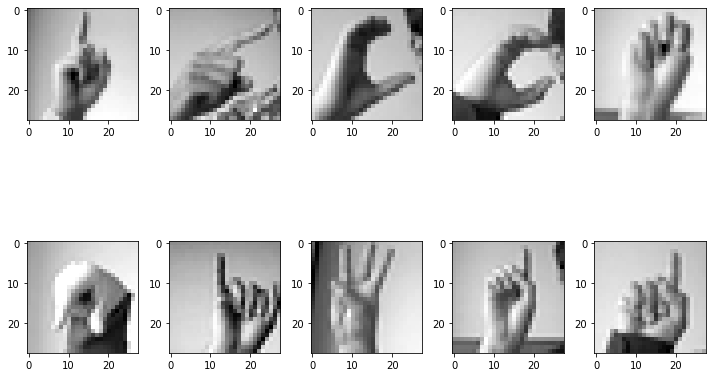

In [33]:
# Spot-checking the first 10 training images
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28, 28) , cmap="gray")
        k += 1
    plt.tight_layout()

In [34]:
print(y_train_df[:10])

0     3
1     6
2     2
3     2
4    13
5    16
6     8
7    22
8     3
9     3
Name: targetVar, dtype: int64


### 3.b) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelBinarizer()
y_train = class_encoder.fit_transform(y_train_df)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (27455, 28, 28, 1) y_train.shape: (27455, 24)


In [36]:
# Finalize the test dataset for the modeling activities
y_test = class_encoder.transform(y_test_df)
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (7172, 28, 28, 1) y_test.shape: (7172, 24)


### 3.c) Data Augmentation

In [37]:
# With data augmentation to prevent overfitting
print('Loading and pre-processing the training images...')
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=default_batch)
print('Number of image batches per epoch of modeling:', len(train_generator))

Loading and pre-processing the training images...
Number of image batches per epoch of modeling: 858


In [38]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Train and Evaluate Models

In [39]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [40]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        # if metric == train_loss:
        #     plt.ylim([0, plt.ylim()[1]])
        # else:
        #     plt.ylim([0.5, 1.1])
        plt.legend()

In [41]:
# Define the baseline model for benchmarking
def create_nn_model(n_inputs=input_image_size, n_outputs=num_class, 
                    conv1_filters=128, conv2_filters=96, conv3_filters=64, 
                    conv1_dropout=0.25, conv2_dropout=0.2, conv3_dropout=0.2, 
                    dense_nodes=512, dense_dropout=0.25, 
                    opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param, input_shape=n_inputs),
        keras.layers.Dropout(conv1_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv2_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), strides=1, padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(conv3_dropout),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(dense_dropout),
        keras.layers.Dense(n_outputs, activation='softmax', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [42]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
reset_random(seedNum)
final_model = create_nn_model()
nn_model_history = final_model.fit(train_generator, validation_data=(X_test, y_test), epochs=default_epoch, batch_size=default_batch, callbacks=[learning_rate_reduction], verbose=1)
print('Total time for model fitting and validating:', (datetime.now() - startTimeModule))

Epoch 1/25
858/858 [==============================] - 11s 13ms/step - loss: 0.8397 - accuracy: 0.7349 - val_loss: 0.7217 - val_accuracy: 0.7652
Epoch 2/25
858/858 [==============================] - 11s 12ms/step - loss: 0.1560 - accuracy: 0.9472 - val_loss: 0.5157 - val_accuracy: 0.8374
Epoch 3/25
858/858 [==============================] - 11s 12ms/step - loss: 0.0998 - accuracy: 0.9654 - val_loss: 0.0613 - val_accuracy: 0.9764
Epoch 4/25
858/858 [==============================] - 11s 12ms/step - loss: 0.0720 - accuracy: 0.9765 - val_loss: 0.6280 - val_accuracy: 0.7917
Epoch 5/25
855/858 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9739
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 [==============================] - 11s 12ms/step - loss: 0.0799 - accuracy: 0.9740 - val_loss: 0.3204 - val_accuracy: 0.8957
Epoch 6/25
858/858 [==============================] - 11s 12ms/step - loss: 0.0266 - accuracy: 0.9906 - val_loss: 0

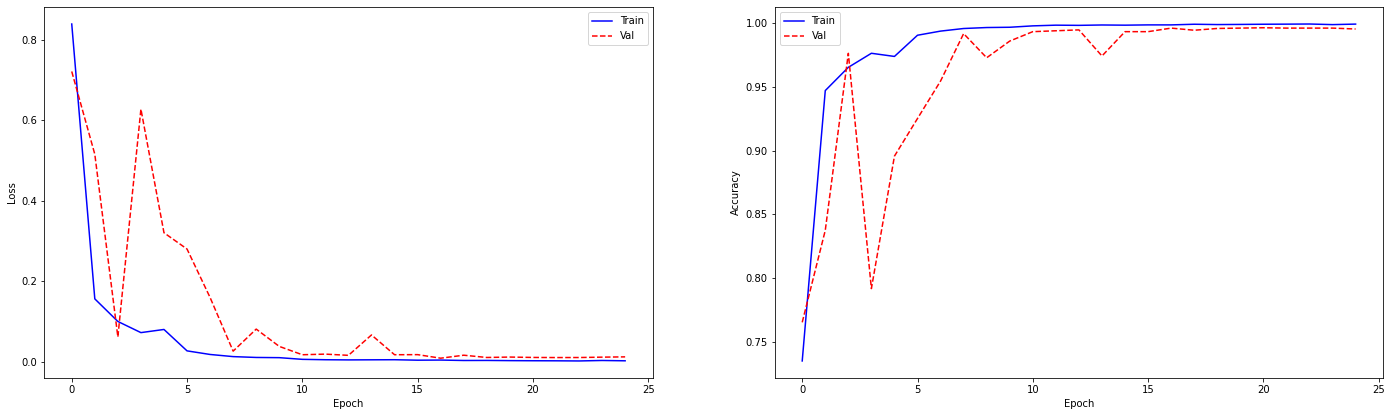

In [43]:
plot_metrics(nn_model_history)

In [44]:
# Summarize the final model
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 96)        110688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 96)        3

In [45]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [46]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [47]:
test_pred = final_model.predict(X_test, batch_size=default_batch, verbose=1)
test_predictions = class_encoder.inverse_transform(test_pred)
test_original = class_encoder.inverse_transform(y_test)
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

225/225 [==============================] - 0s 1ms/step
Accuracy Score: 0.9955382041271612
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 431   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 244   0   0   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0]
 [  0   0   0   0 479   0   0   0   0   0   0  19   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 348   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   5 431   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 288   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 

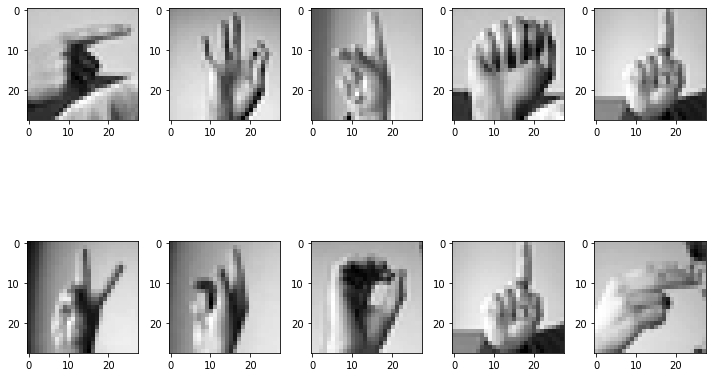

In [48]:
# Spot-checking the first 10 test images
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_test[k].reshape(28, 28) , cmap="gray")
        k += 1
    plt.tight_layout()

In [49]:
print(test_predictions[:10])

[ 6  5 10  0  3 21 10 14  3  7]


In [50]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:04:52.335641
